# Table of Contents
[Section 1 - Introduction](#Introduction)\
[Section 2 - Loading Dataset](#LoadingDataset)\
[Section 3 - Data Cleaning and Transforming the Data](#DataCleaningandTransformingtheData)\
[Section 4 - Example](#Example)\
[Section 5 - Calculating Stability of wOBA Against](#CalculatingStabilityofwOBAAgainst)\
[Section 6 - Visualizing the Results](#VisualizingResults)\
[Section 7 - Discussion](#Discussion)\
[Section 8 - References](#References)

<a id='Introduction'></a>

# Section 1 - Introduction

This project is part of a series of projects where I aim to optimize every pitcher's pitch mix. For this project a pitcher's *pitch mix* is defined as the percentage thrown of each of their pitch types. For example, Cory Abbott's pitch mix in 2022 was 50.9% four-seam fastball, 22.2% knuckle curve, 26.9% slider.

For this project an *optimal pitch mix* is defined as the pitch mix that minimizes batter success against the pitcher. Batter success against a pitcher and pitcher success is generally complementary, as you can view a plate appearance in the as a matchup of two players with opposite interests. In the broader context of the game the batter wants their team to score runs and the pitcher doesn't want the batter's team to score runs. In the narrower context of a single plate appearance the result of the matchup contributes to both players' broader goals. How much the result of the plate appearance contributes to either player's goal depends on many factors such as the situation in the game and the result of the plate appearance itself. Since determining the level of success attributed to the result of the plate appearance is nuanced, claiming that batter success is exactly complementary of pitcher success is naive. However, it serves as a general benchmark that in a plate appearance the batter is successful if the result is one that contributes positively to their team's run scoring, and the pitcher is successful if they prevent those results.

The statistic that I've chosen to measure pitcher success is *wOBA against* (called *wOBA* from here on). You can read more about wOBA on *Fangraphs* [here](https://library.fangraphs.com/offense/woba/).

The first reason that I've chosen to use wOBA is that it better represents the value of events to a team's run scoring (or run prevention from the pitching team's perspective) than traditional batting (batting against) statistics.

The second reason is that it is inclusive of a larger set of events than traditional pitching stats. Traditional pitching stats like ERA or FIP look at run scoring on a more binary scale than wOBA, and don't reflect the events that contribute to run scoring. For example, a pitcher allowing a double is a negative event for them, but whether that event is reflected in their ERA depends on the events after the double.

The third, and final, reason that I've chosen wOBA is that is limited to the results of plate appearances. For a pitcher, getting looking or swinging strikes is generally good and having the batter take balls is generally bad, but their relationship to team run prevention is more complex than the results of a plate appearance.

Part of what makes pitchers successful is ensuring that the batter doesn't know what pitch type is coming next. It is likely that if a pitcher throws a pitch type more or less often in a given time period then batters may have different results against that pitch type in that time period.

My motivation for this series of projects comes from the understanding that pitchers should throw their best pitch type(s) (in a vacuum, without considering use) as often as they can, but without throwing them too often to the point of increased batter performance against the pitch type(s) due to familiarity.

In this project I will determine how stable a pitcher's wOBA becomes as the number of pitches that they throw increases, and I will use these results to select a sample size of pitches to use when modeling how an increase or decrease in use of a pitch type affects that pitcher's wOBA against that pitch type.

The way that I will measure stability is inspired by the work done by Russell Carleton (aka Pizza Cutter) [here](https://web.archive.org/web/20080102094412/http:/mvn.com/mlb-stats/2007/11/14/525600-minutes-how-do-you-measure-a-player-in-a-year/). The measurement of *stability* at a given sample size of pitches is a measure of the [*Pearson correlation coefficient*](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) (called *correlation* from here on) between a pitcher's wOBA in the sample that size and their wOBA in all of their other samples of that size. Pitchers who threw a large number of pitches will have many samples to measure correlation between, and as the sample size of pitches increases the number of samples for each pitcher, and in the dataset, will decrease.

The correlation between wOBA in samples of pitches is measured within samples only from that pitcher to ensure that I am comparing samples of the same "true wOBA skill", and not comparing to a pitcher who may have different "true wOBA skill". For this reason, at a given sample size of pitches only those pitchers who have thrown at least twice that number of pitches will be considered.

I will use a variation of [*split-half*](https://www.statisticshowto.com/split-half-reliability/) sampling when looking at wOBA in a sample of pitches. Across all pitches in the sample for a pitcher, I will create samples by assigning alternating sample numbers to their pitches. For example, if a player threw exactly 1000 pitches and I'm considering samples of 500 pitches, one sample would be all of their odd numbered pitches and their other sample would be all of their even numbered pitches. For pitchers who threw more than two times the number of pitches in the sample size the groups will be alternated in a similar way, their first pitch will be assigned to their first sample, their second pitch to their second sample, their third pitch to their third sample, and continuing until reaching their pitch number that corresponds to their number of samples of the sample size. After reaching this number, their next pitch will be assigned to their first sample, their next pitch to their second sample, and so on. The reason that I'm choosing to sample this way, rather than assigning their first sample size of pitches into the first sample, their second sample size of pitches into their second sample, and so on, is to control for the fact that their "true wOBA skill" may change over time. By alternating the groups that the pitches are assigned to, each sample contains pitches from each time period. 

<a id='LoadingDataset'></a>

# Section 2 - Loading Dataset

I will import several packages from standard Python libraries for data manipulation and data plotting. I will also import the [*statcast*](https://github.com/jldbc/pybaseball/blob/master/docs/statcast.md) package from the [*pybaseball*](https://pypi.org/project/pybaseball/) library, which I will use to gather the data.

In [1]:
# import standard python packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# import the statcast package
from pybaseball import statcast

The data that I will use is from the entire 2022 MLB season. The documentation for the columns in the dataset can be found [here](https://baseballsavant.mlb.com/csv-docs).

In [2]:
# load statcast dataset and store in pitches DataFrame
# first day of season was April 7, 2022
# last day of season was October 5, 2022
pitches = statcast(start_dt="2022-04-07", end_dt="2022-10-05")

This is a large query, it may take a moment to complete


/Users/jackhinde/anaconda3/lib/python3.10/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|█████████████████████████████████████████| 182/182 [04:23<00:00,  1.45s/it]


In [3]:
# TEMPORARY - read pitches from csv file
# pitches = pd.read_csv('statcast_pitches.csv')

In order to create samples of a certain number of pitches, the dataset must be ordered chronologically by games played for each pitcher. The way that I will do this is by ordering the dataset by the game date, then the game number (to distiguish between games played on the same day), then the plate appearance number in the game, and then the pitch number in the plate appearance.

Below is a subset of columns pertaining to the game situation from the first 30 pitches of the dataset. The data shows the game played on Opening Day of 2022 between the Houston Astros and the Los Angeles Angels. The data shows that Shohei Ohtani threw a total of 19 pitches to 5 batters in the top of the first inning, Framber Valez needed just 9 pitches to retire all three batters faced in the bottom of the first inning, and that Shohei Ohtani threw at least two pitches to the Astros' first batter to begin the top of the second inning. More importantly, the data is ordered in a way that I can create samples of pitches.

The dataset is not exactly chronologically ordered in terms of the exact date and time that the pitch was thrown (oftentimes multiple games are being played simultaneously), but it is ordered in a way that every pitch that a pitcher threw is before a pitch that was thrown later in time by them in the dataset which is enough to create samples of pitches for each pitcher.

In [4]:
# sort dataset by date of game, game id, plate appearance of game, then the pitch number of the plate appearance
pitches = pitches.sort_values(by=['game_date', 'game_pk', 'at_bat_number', 'pitch_number'])

# view first 30 rows of subset of columns
pitches[['game_date', 'player_name', 'batter', 'pitcher', 'home_team', 'game_pk', 'at_bat_number', 'pitch_number']].head(30)

,game_date,player_name,batter,pitcher,home_team,game_pk,at_bat_number,pitch_number
1981,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,1
1914,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,2
1891,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,3
1775,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,4
1729,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,5
1659,2022-04-07,"Ohtani, Shohei",488726,660271,LAA,661042,2,1
1618,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,3,1
1542,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,3,2
1496,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,3,3
1412,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,3,4


<a id='DataCleaningandTransformingtheData'></a>

# Section 3 - Data Cleaning and Transforming the Data

## Creating Binary Event Identifier Columns

In order to calculate a pitcher's wOBA in a sample of pitches, I declare two functions to create columns in the dataset corresponding to whether the result of the pitch was an event that is used in the calculation.

$wOBA = \frac{(wuBB * uBB) + (wHBP * HBP) + (w1B * 1B) + (w2B * 2B) + (w3B * 3B) + (wHR * HR)}{AB + BB - IBB + SF + HBP}$

Above is the formula for wOBA. The calculation depends on walks (both intentional and unintentional), hit by pitches, singles, doubles, triples, home runs, at-bats, and sacrifice flies. Identifiers for each of those events occurring on that pitch will be added to the dataset. 

The statcast dataset doesn't contain any data on intentional walks. This is likely because of the 2017 rule change allowing managers to automatically give the batter a free pass without throwing four pitches outside the zone, meaning that an intentional walk is not a pitch-level event.

This doesn't pose any problems for this project as intentional walks are subtracted from total walks (intentional and unintentional) as to not be reflected in the calculation. This means that the formula for wOBA that I will use is the equivalent representation as follows. 

$wOBA = \frac{(wuBB * uBB) + (wHBP * HBP) + (w1B * 1B) + (w2B * 2B) + (w3B * 3B) + (wHR * HR)}{AB + uBB + SF + HBP}$

Below are the weights of events for the 2022 season that I will use for calculating wOBA. The weights were found on *Fangraphs* [here](https://www.fangraphs.com/guts.aspx?type=cn).

In [5]:
# store 2022 wOBA weights of events
wubb = 0.689
whbp = 0.720
wx1b = 0.884
wx2b = 1.261
wx3b = 1.601
whr = 2.072

The two functions that I will use to identify certain events differ by how events are represented in the *statcast* dataset. In the *events* column, some events are represented only one way, and others can have multiple ways to represent it. The primary case where this will be relevant is for identifying the end of an at-bat. There are a number of ways that the end of an at-bat is represented in the *events* column, as the end of an at-bat is represented by what happened to end it (i.e a hit, a putout, etc.), so there are many possible results to search for. This also occurs when identifying sacrifice flies, as they are represented differently if the tagging runner is thrown out or not.

In [6]:
def create_binary_events_column_single(event, column_name):
    '''
    Creates a column in the pitches DataFrame with column name 'column_name' having value 1 if the pitch event was 'event' and value 0 if the pitch event was not 'event'.
    Searches for a single type of pitch event.
            
            Parameters:
                    event (str): The event to be searched for as a string.
                    column_name (str): The name of the created column as a string.
    '''
    # add boolean column for event
    pitches[column_name] = pitches['events'] == event
    # convert to binary
    pitches[column_name] = pitches[column_name].replace({True: 1, False: 0})

In [7]:
def create_binary_events_column_multiple(events, column_name):
    '''
    Creates a column in the pitches DataFrame with column name 'column_name' having value 1 if the pitch event was one of 'events' and value 0 if the pitch event was not one of 'events'.
    Searches for a multiple types of pitch events.
            
            Parameters:
                    events (list): The events to be searched for as a list of strings.
                    column_name (str): The name of the created column as a string.
    '''
    # add boolean column for events
    pitches[column_name] = pitches['events'].isin(events)
    # convert to binary
    pitches[column_name] = pitches[column_name].replace({True: 1, False: 0})

In [8]:
# list of events that end an at-bat
ab_events = ['double', 'double_play', 'field_error', 'field_out', 'fielders_choice', 'fielders_choice_out', 'force_out', 'grounded_into_double_play', 'home_run', 'other_out', 'single', 'strikeout', 'strikeout_double_play', 'triple', 'triple_play']
# add binary event column for the end of of an at-bat
create_binary_events_column_multiple(ab_events, 'ab')

# add binary event columns for certain events
create_binary_events_column_single('walk', 'ubb')
create_binary_events_column_single('hit_by_pitch', 'hbp')
create_binary_events_column_single('single', 'x1b')
create_binary_events_column_single('double', 'x2b')
create_binary_events_column_single('triple', 'x3b')
create_binary_events_column_single('home_run', 'hr')

# list of events that are sacrifice flies
sf_events = ['sac_fly', 'sac_fly_double_play']
# add binary event column for a sacrifice fly
create_binary_events_column_multiple(sf_events, 'sf')

# view season totals for each event
pitches.groupby(['player_name', 'pitcher'])[['ab', 'x1b', 'x2b', 'x3b', 'hr', 'ubb', 'hbp', 'sf']].sum().head()

,,ab,x1b,x2b,x3b,hr,ubb,hbp,sf
player_name,pitcher,,,,,,,,
"Abbott, Cory",676265,184,20,12,0,12,25,5,2
"Abreu, Albert",656061,144,25,5,0,5,22,3,2
"Abreu, Bryan",650556,217,36,7,0,2,26,4,1
"Acevedo, Domingo",642758,243,29,11,1,9,13,3,1
"Adam, Jason",592094,211,22,3,1,5,15,6,2


Above we can see those stats for the first five pitchers alphabetically in the dataset. I have chosen to represent singles, doubles, and triples with x1b, x2b, and x3b, respectively, as to avoid beginning a column name with a number.

## Creating a Season Pitch Count

Since the data is sorted chronologically for each pitcher, I can aggregate by pitcher and number each pitcher's pitches in their season. 

In [9]:
# create column containing season pitch count
# .cumcount() starts at 0, add 1 to start count at 1
pitches['season_pitch_number'] = pitches.groupby(['player_name', 'pitcher']).cumcount() + 1

# view first 10 rows of subset of columns
pitches[['game_date', 'player_name', 'batter', 'pitcher', 'home_team', 'game_pk', 'at_bat_number', 'pitch_number', 'season_pitch_number']].head(10)

,game_date,player_name,batter,pitcher,home_team,game_pk,at_bat_number,pitch_number,season_pitch_number
1981,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,1,1
1914,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,2,2
1891,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,3,3
1775,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,4,4
1729,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,5,5
1659,2022-04-07,"Ohtani, Shohei",488726,660271,LAA,661042,2,1,6
1618,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,3,1,7
1542,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,3,2,8
1496,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,3,3,9
1412,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,3,4,10


Here are the same columns that were previously looked to ensure that the sorting was done properly, with their season pitch count included.

<a id='Example'></a>

# Section 4 - Example

I will now illustrate an example to show how I will calculate the correlation between samples. For this example, I will look at just five pitchers who appeared in the 2022 season. These pitchers were selected for this example because they were among the first pitchers to appear in the dataset, and to illustrate how this calculation handles pitchers with varying numbers of pitches thrown in the season.

For this example, I will be calculating the correlation between samples of 500 pitches. The pitchers that I'm selecting are Shohei Ohtani, Framber Valdez, Aaron Loup, Phil Maton, and Max Fried.

In [10]:
# create list of pitchers to include in example
pitchers_ex = ['Ohtani, Shohei', 'Valdez, Framber', 'Loup, Aaron', 'Maton, Phil', 'Fried, Max']
# create example pitches DataFrame containing only selected pitchers' data
pitches_ex = pitches[pitches['player_name'].isin(pitchers_ex)]

# view the example DataFrame
pitches_ex.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,delta_run_exp,ab,ubb,hbp,x1b,x2b,x3b,hr,sf,season_pitch_number
1981,FF,2022-04-07,99.8,-2.19,5.82,"Ohtani, Shohei",514888,660271,NaN,ball,...,0.033,0,0,0,0,0,0,0,0,1
1914,FF,2022-04-07,97.9,-2.16,5.89,"Ohtani, Shohei",514888,660271,NaN,called_strike,...,-0.043,0,0,0,0,0,0,0,0,2
1891,FF,2022-04-07,99.2,-2.13,5.87,"Ohtani, Shohei",514888,660271,NaN,ball,...,0.049,0,0,0,0,0,0,0,0,3
1775,ST,2022-04-07,86.9,-2.29,5.77,"Ohtani, Shohei",514888,660271,NaN,called_strike,...,-0.066,0,0,0,0,0,0,0,0,4
1729,FS,2022-04-07,91.8,-1.76,6.04,"Ohtani, Shohei",514888,660271,strikeout,called_strike,...,-0.195,1,0,0,0,0,0,0,0,5


The first step is to look at the number of pitches that each pitcher threw, or their season pitch count. This will be equal to the maximum of their season pitch number.

In [11]:
# create DataFrame holding number of pitches thrown in season by pitcher
# number of pitches thrown is equivalent to the maximum of the season pitch count
pitcher_seasons_ex = pitches_ex.groupby(['player_name', 'pitcher']).agg({'season_pitch_number': 'max'})

pitcher_seasons_ex.head()

,,season_pitch_number
player_name,pitcher,
"Fried, Max",608331,2818
"Loup, Aaron",571901,967
"Maton, Phil",664208,1089
"Ohtani, Shohei",660271,2629
"Valdez, Framber",664285,3018


Their number of samples of 500 pitches will be equal to the largest whole number when dividing their season pitch count by 500.

In [12]:
# add column for the number of samples of the sample size for each player
# use // for integer division, round to lowest whole number
pitcher_seasons_ex['num_samples'] = pitcher_seasons_ex['season_pitch_number'] // 500

pitcher_seasons_ex.head()

,,season_pitch_number,num_samples
player_name,pitcher,,
"Fried, Max",608331,2818,5
"Loup, Aaron",571901,967,1
"Maton, Phil",664208,1089,2
"Ohtani, Shohei",660271,2629,5
"Valdez, Framber",664285,3018,6


In [13]:
# filter the data for only pitchers who have two or more samples of 500 pitches
# this removes pitchers who have thrown less than 1000 pitches
pitcher_seasons_ex = pitcher_seasons_ex[pitcher_seasons_ex['num_samples'] > 1]
# subset columns to keep only player_name, pitcher, num_samples
pitcher_seasons_ex = pitcher_seasons_ex[['num_samples']]

pitcher_seasons_ex.head()

,,num_samples
player_name,pitcher,
"Fried, Max",608331,5
"Maton, Phil",664208,2
"Ohtani, Shohei",660271,5
"Valdez, Framber",664285,6


In the previous step Aaron Loup was removed since he threw only 967 pitches in 2022. Considering a sample size of 500 pitches, he doesn't have two samples to compare to each other.

In [14]:
# add column containing number of samples of sample size to pitches DataFrame
# use inner join to filter pitchers who have thrown less than twice the sample size
pitches_ex = pitches_ex.join(pitcher_seasons_ex, on=['player_name', 'pitcher'], how='inner')

# view DataFrame with number of samples
pitches_ex[['game_date', 'player_name', 'batter', 'pitcher', 'home_team', 'game_pk', 'season_pitch_number', 'num_samples']].head()

,game_date,player_name,batter,pitcher,home_team,game_pk,season_pitch_number,num_samples
1981,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,5
1914,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,2,5
1891,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,3,5
1775,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,4,5
1729,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,5,5


The number of samples of 500 pitches that each pitcher has in the 2022 season is now in the dataset. This will be used to create samples of exactly 500 pitches. For example, Max Fried threw 2818 pitches in 2022 so he has five samples of 500 pitches. This means that he threw 318 "extra" pitches that don't belong to a sample.

The way that these "extra" pitches will be removed is by filtering by the first samples of pitches evenly fitting into a sample that occurred. In Fried's case, his last 318 pitches will be removed.

In [15]:
# filter the data for pitches not in a sample
# these are extra pitches
pitches_ex = pitches_ex[pitches_ex['season_pitch_number'] <= (pitches_ex['num_samples'] * 500)]

# view number of pitches that were thrown in filtered dataset
pitches_ex.groupby(['player_name', 'pitcher']).agg({'season_pitch_number': 'max'}).head()

,,season_pitch_number
player_name,pitcher,
"Fried, Max",608331,2500
"Maton, Phil",664208,1000
"Ohtani, Shohei",660271,2500
"Valdez, Framber",664285,3000


The next step is to assign a sample number to each pitch. This is done by taking the whole number remainder when dividing their season pitch count by 500. Performing this mod arithmetic on the season pitch number means that the pitch numbers that are didvided by their number of samples evenly are assigned to group 0. For example, Max Fried's first pitch was assigned to group 1, his second to group 2, his third to group 3, his fourth to group 4, and his fifth to group 0. 

This doesn't pose a problem for the analysis, as the correlation will be measured between all samples and not just consecutive split-samples, it is just something to be aware of.

In [16]:
# calculate sample number for each pitch
pitches_ex['sample_number'] = pitches_ex['season_pitch_number'] % pitches_ex['num_samples']

# view first 10 pitches with sample number
pitches_ex[['game_date', 'player_name', 'batter', 'pitcher', 'home_team', 'game_pk', 'season_pitch_number', 'num_samples', 'sample_number']].head(10)

,game_date,player_name,batter,pitcher,home_team,game_pk,season_pitch_number,num_samples,sample_number
1981,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,5,1
1914,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,2,5,2
1891,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,3,5,3
1775,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,4,5,4
1729,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,5,5,0
1659,2022-04-07,"Ohtani, Shohei",488726,660271,LAA,661042,6,5,1
1618,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,7,5,2
1542,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,8,5,3
1496,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,9,5,4
1412,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,10,5,0


Now I can calculate each pitcher's wOBA in each sample by aggregating the number of events by pitcher and the sample number.

In [17]:
# create MultiIndex containing number of events in each sample
woba_sample_ex = pitches_ex.groupby(['player_name', 'pitcher', 'sample_number'])[['ab', 'x1b', 'x2b', 'x3b', 'hr', 'ubb', 'hbp', 'sf']].agg({'ab': 'sum', 'x1b': 'sum', 'x2b': 'sum', 'x3b': 'sum', 'hr': 'sum', 'ubb': 'sum', 'hbp': 'sum', 'sf': 'sum'})
# calculate woba in sample
woba_sample_ex['woba'] = ((wx1b * woba_sample_ex['x1b']) + (wx2b * woba_sample_ex['x2b']) + (wx3b * woba_sample_ex['x3b']) + (whr * woba_sample_ex['hr']) + (wubb * woba_sample_ex['ubb']) + (whbp * woba_sample_ex['hbp'])) / (woba_sample_ex['ab'] + woba_sample_ex['ubb'] + woba_sample_ex['hbp'] + woba_sample_ex['sf'])
# round wOBA to three decimals
woba_sample_ex = woba_sample_ex.round({'woba': 3})
# filter colums to remove events, keep wOBA column
woba_sample_ex = woba_sample_ex[['woba']]

# view the first ten rows
# round wOBA to three decimals
woba_sample_ex.round({'woba': 3}).head(10)

woba
player_name    pitcher sample_number       
Fried, Max     608331  0              0.315
                       1              0.263
                       2              0.258
                       3              0.210
                       4              0.210
Maton, Phil    664208  0              0.366
                       1              0.274
Ohtani, Shohei 660271  0              0.234
                       1              0.319
                       2              0.231

In [18]:
# get number of samples of the sample size
# this is the length of the DataFrame
print(len(woba_sample_ex.index))

18


There are 18 samples of 500 pitches in the example dataset. This is important information to keep track of, especially when using these results to select a sample size of pitches to use when modeling how an increase or decrease in use of a pitch type affects that pitcher's wOBA against that pitch type.

While the sample size that best stabilizes wOBA should be selected, the number of samples will decrease the bias in modeling the change in wOBA as an effect of changing pitch use, and should create a more accurate model.

To compute the correlation between samples, the [*pandas.DataFrame.corr*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) function will be used. This function computes the correlation between columns in a DataFrame.

Currently the dataset is indexed by pitcher and by the sample. By flattening the DataFrame, the sample number becomes a column to use for calculating between-column correlations. Pitchers who have thrown fewer pitches, like Phil Maton, will have fewer columns to use for calculating correlation.

In [19]:
# widen DataFrame to have samples as columns
woba_sample_ex = woba_sample_ex.unstack(level=-1)

# view the wOBA by sample
# round sample wOBA to three decimals
woba_sample_ex.round({'0': 3, '1': 3, '2': 3, '3': 3, '4': 3, '5': 3}).head()

woba                                 
sample_number                0      1      2      3      4    5
player_name     pitcher                                        
Fried, Max      608331   0.315  0.263  0.258  0.210  0.210  NaN
Maton, Phil     664208   0.366  0.274    NaN    NaN    NaN  NaN
Ohtani, Shohei  660271   0.234  0.319  0.231  0.251  0.277  NaN
Valdez, Framber 664285   0.254  0.280  0.262  0.264  0.275  0.3

In [20]:
# create DataFrame holding correlations between columns
# set numeric_only=True to ignore NA values in woba_sample columns
# these NA values correspond to pitchers who have thrown more than twice the number of pitches in the sample size (have more than two samples)
# but don't have the max number of samples 
correlations_ex = woba_sample_ex.corr(numeric_only=True)

# view between-column correlations
# round correlations to four decimals
correlations_ex.round({'0': 4, '1': 4, '2': 4, '3': 4, '4': 4, '5': 4}).head()

woba                                            
sample_number              0         1         2         3         4   5
     sample_number                                                      
woba 0              1.000000 -0.706447  0.600389 -0.890661 -0.977393 NaN
     1             -0.706447  1.000000 -0.913315  0.557550  0.751539 NaN
     2              0.600389 -0.913315  1.000000 -0.171141 -0.417732 NaN
     3             -0.890661  0.557550 -0.171141  1.000000  0.966657 NaN
     4             -0.977393  0.751539 -0.417732  0.966657  1.000000 NaN

Here is the between-column correlation matrix. The correlation between any column and itself is one, and since Framber Valdez was the only pitcher with six samples the correlation between any column and the column of fifth samples is NaN. The correlation between two columns is symmetric, or $r_{i,j}=r_{j,i}$, where $r_{i,j}$ is the Pearson correlation coefficient between column $i$ and column $j$.

For example, the correlation between all of the pitchers' first samples and their last samples (in sample 0) is $r_{0,1} = r_{1,0} = -0.7064$. I will now weigh the correlation coefficients by the number of pitchers who have both of those samples to get a correlation coefficient for the wOBA of those pitchers in 500 pitch samples.

In [21]:
print(round(correlations_ex.iloc[1, 0], 4))

-0.7064


Looking at the zeroth and first samples, there were four pitchers who had those samples of 500 pitches. This is seen in the *woba_sample_ex* DataFrame, and it can be verified by taking the minimum count of non-NaN values in each column.

In [22]:
print(min(woba_sample_ex.iloc[:, 0].count(), woba_sample_ex.iloc[:, 1].count()))

4


To report the average correlation coefficient weighted by the number of pitchers who had those samples, I will create a running total of the weighted coefficient, and a running total of the number of pitcher-samples.

Because the correlation matrix is symmetric, I will just consider the non-NaN values below the diagonal in the correlation matrix.

In [23]:
# initialize sum of weighted correlation coefficients
weighted_correlation_ex = 0
# initialize total number of pitcher-samples
num_pitcher_samples_ex = 0

# add correlation coefficient between columns weighted by number of samples in column 1 and column 0 pairing
weighted_correlation_ex += correlations_ex.iloc[1, 0] * min(woba_sample_ex.iloc[:, 1].count(), woba_sample_ex.iloc[:, 0].count())
# add number of samples in column 1 and column 0 pairing
num_pitcher_samples_ex += min(woba_sample_ex.iloc[:, 1].count(), woba_sample_ex.iloc[:, 0].count())

This is then repeated for all entries below the diagonal in the correlation matrix.

In [24]:
# add correlation coefficient between columns weighted by number of samples in column 2 and column 0 pairing
weighted_correlation_ex += correlations_ex.iloc[2, 0] * min(woba_sample_ex.iloc[:, 2].count(), woba_sample_ex.iloc[:, 0].count())
# add number of samples in column 2 and column 0 pairing
num_pitcher_samples_ex += min(woba_sample_ex.iloc[:, 2].count(), woba_sample_ex.iloc[:, 0].count())

# add correlation coefficient between columns weighted by number of samples in column 2 and column 1 pairing
weighted_correlation_ex += correlations_ex.iloc[2, 1] * min(woba_sample_ex.iloc[:, 2].count(), woba_sample_ex.iloc[:, 1].count())
# add number of samples in column 2 and column 1 pairing
num_pitcher_samples_ex += min(woba_sample_ex.iloc[:, 2].count(), woba_sample_ex.iloc[:, 1].count())

# add correlation coefficient between columns weighted by number of samples in column 3 and column 0 pairing
weighted_correlation_ex += correlations_ex.iloc[3, 0] * min(woba_sample_ex.iloc[:, 3].count(), woba_sample_ex.iloc[:, 0].count())
# add number of samples in column 3 and column 0 pairing
num_pitcher_samples_ex += min(woba_sample_ex.iloc[:, 3].count(), woba_sample_ex.iloc[:, 0].count())

# add correlation coefficient between columns weighted by number of samples in column 3 and column 1 pairing
weighted_correlation_ex += correlations_ex.iloc[3, 1] * min(woba_sample_ex.iloc[:, 3].count(), woba_sample_ex.iloc[:, 1].count())
# add number of samples in column 3 and column 1 pairing
num_pitcher_samples_ex += min(woba_sample_ex.iloc[:, 3].count(), woba_sample_ex.iloc[:, 1].count())

# add correlation coefficient between columns weighted by number of samples in column 3 and column 2 pairing
weighted_correlation_ex += correlations_ex.iloc[3, 2] * min(woba_sample_ex.iloc[:, 3].count(), woba_sample_ex.iloc[:, 2].count())
# add number of samples in column 3 and column 2 pairing
num_pitcher_samples_ex += min(woba_sample_ex.iloc[:, 3].count(), woba_sample_ex.iloc[:, 2].count())

# add correlation coefficient between columns weighted by number of samples in column 4 and column 0 pairing
weighted_correlation_ex += correlations_ex.iloc[4, 0] * min(woba_sample_ex.iloc[:, 4].count(), woba_sample_ex.iloc[:, 0].count())
# add number of samples in column 4 and column 0 pairing
num_pitcher_samples_ex += min(woba_sample_ex.iloc[:, 4].count(), woba_sample_ex.iloc[:, 0].count())

# add correlation coefficient between columns weighted by number of samples in column 4 and column 1 pairing
weighted_correlation_ex += correlations_ex.iloc[4, 1] * min(woba_sample_ex.iloc[:, 4].count(), woba_sample_ex.iloc[:, 1].count())
# add number of samples in column 4 and column 1 pairing
num_pitcher_samples_ex += min(woba_sample_ex.iloc[:, 4].count(), woba_sample_ex.iloc[:, 1].count())

# add correlation coefficient between columns weighted by number of samples in column 4 and column 2 pairing
weighted_correlation_ex += correlations_ex.iloc[4, 2] * min(woba_sample_ex.iloc[:, 4].count(), woba_sample_ex.iloc[:, 2].count())
# add number of samples in column 4 and column 2 pairing
num_pitcher_samples_ex += min(woba_sample_ex.iloc[:, 4].count(), woba_sample_ex.iloc[:, 2].count())

# add correlation coefficient between columns weighted by number of samples in column 4 and column 3 pairing
weighted_correlation_ex += correlations_ex.iloc[4, 3] * min(woba_sample_ex.iloc[:, 4].count(), woba_sample_ex.iloc[:, 3].count())
# add number of samples in column 4 and column 3 pairing
num_pitcher_samples_ex += min(woba_sample_ex.iloc[:, 4].count(), woba_sample_ex.iloc[:, 3].count())

# print sum of correlation coefficients weighted by number of samples in pairing
# round correlation to four decimals
print(f"sum of weighted correlation coefficients: {round(weighted_correlation_ex, 4)}")
# print total number of samples in all pairings
print(f"total number of samples: {num_pitcher_samples_ex}")

sum of weighted correlation coefficients: -4.3081
total number of samples: 31


The weighted average of the correlation between the pitchers' samples can be found by dividing the sum of the weighted correlation coefficients by the total number of samples.

In [25]:
# calculate weighted average of between-column correlations
# equal to the sum of wighted column correlations divided by the total number of samples in all pairings
correlation_ex = weighted_correlation_ex / num_pitcher_samples_ex
print(round(correlation_ex, 4))

-0.139


The Pearson correlation coefficient between the four pitchers' wOBA in samples of 500 pitches was -0.1390.

The above steps of weighing and adding the coefficients can be generalized to a correlation matrix of any size by using the number of columns in the *woba_sample_ex* DataFrame retrieved with the [*pandas.DataFrame.shape*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shape.html) function.

The number of columns can be iterated over, with the index starting at 1 (the 0th row in the correlation matrix doesn't have any row-column entries below the diagonal), and a second index can iterate from 0 up to (but not including) the first index. This will produce all entries below the diagonal in the correlation matrix.

In [26]:
print(woba_sample_ex.shape)

(4, 6)


The correlation coefficients where there is one pitcher-sample can be skipped by first testing for NaN in the correlation matrix

In [27]:
# test for NaN in the first row and zeroth column in the correlations matrix
# use not() to be true when the value is not NaN
print(not(np.isnan(correlations_ex.iloc[1, 0])))

True


In [28]:
# test for NaN in the first row and zeroth column in the correlations matrix
# use not() to be true when the value is not NaN
print(not(np.isnan(correlations_ex.iloc[5, 0])))

False


<a id='CalculatingStabilityofwOBAAgainst'></a>

# Section 5 - Calculating Stability of wOBA Against

The same general steps that were taken to calculate the correlation of samples of 500 pitches for the five pitchers will be repeated with all pitchers in the dataset, from samples of 50 to 1500 pitches, in increments of 50 pitches. For all sample sizes, the Pearson correlation coefficient and the number of samples of that size (not the total number of between-column samples, but the two plus samples of each pitcher who have thrown twice the sample size of pitches) will be stored.

In [29]:
# initialize arrays to hold results
sample_sizes_array = np.array([0])
correlations_array = np.array([0])
num_samples_array = np.array([0])

# test sample sizes from 50 to 1500 pitches, by 50
for sample_size in range(50, 1550, 50):
    # append sample size being tested to array
    sample_sizes_array = np.concatenate((sample_sizes_array, np.array([sample_size])), axis=0)
    
    # create DataFrame holding number of pitches thrown in season by pitcher
    # number of pitches thrown is equivalent to the maximum of the season pitch count
    pitcher_seasons = pitches.groupby(['player_name', 'pitcher']).agg({'season_pitch_number': 'max'})
    # add column for the number of samples of the sample size for each player
    # use // for integer division, round to lowest whole number
    pitcher_seasons['num_samples'] = pitcher_seasons['season_pitch_number'] // sample_size
    # filter the data for only pitchers who have two or more samples of the sample size
    # this removes pitchers who have thrown less than twice the number of pitches in the sample size
    pitcher_seasons = pitcher_seasons[pitcher_seasons['num_samples'] > 1]
    # subset columns to keep only player_name, pitcher, num_samples
    pitcher_seasons = pitcher_seasons[['num_samples']]

    # create pitches_alias DataFrame as copy of pitches DataFrame with column containing number of samples of sample size
    # use inner join to filter pitchers who have thrown less than twice the sample size
    # must create different DataFrame as to not change pitches DataFrame for next iteration
    pitches_alias = pitches.join(pitcher_seasons, on=['player_name', 'pitcher'], how='inner')

    # filter the data for pitches not in a sample
    # these are extra pitches
    pitches_alias = pitches_alias[pitches_alias['season_pitch_number'] <= (pitches_alias['num_samples'] * sample_size)]

    # calculate sample number for each pitch
    pitches_alias['sample_number'] = pitches_alias['season_pitch_number'] % pitches_alias['num_samples']

    # create DataFrame containing number of events in each sample
    woba_sample = pitches_alias.groupby(['player_name', 'pitcher', 'sample_number'])[['ab', 'x1b', 'x2b', 'x3b', 'hr', 'ubb', 'hbp', 'sf']].agg({'ab': 'sum', 'x1b': 'sum', 'x2b': 'sum', 'x3b': 'sum', 'hr': 'sum', 'ubb': 'sum', 'hbp': 'sum', 'sf': 'sum'})
    # calculate woba in sample
    woba_sample['woba'] = ((wx1b * woba_sample['x1b']) + (wx2b * woba_sample['x2b']) + (wx3b * woba_sample['x3b']) + (whr * woba_sample['hr']) + (wubb * woba_sample['ubb']) + (whbp * woba_sample['hbp'])) / (woba_sample['ab'] + woba_sample['ubb'] + woba_sample['hbp'] + woba_sample['sf'])
    # filter colums to remove events, keep wOBA column
    woba_sample = woba_sample[['woba']]

    # get number of samples of the sample size
    # this is the length of the woba_sample DataFrame
    num_samples = len(woba_sample.index)
    # append number of samples to array
    num_samples_array = np.concatenate((num_samples_array, np.array([num_samples])), axis=0)

    # widen DataFrame to have samples as columns
    woba_sample = woba_sample.unstack(level=-1)

    # create DataFrame holding correlations between columns
    # set numeric_only=True to ignore NA values in woba_sample columns
    # these NA values correspond to pitchers who have thrown more than twice the number of pitches in the sample size (have more than two samples)
    # but don't have the max number of samples 
    correlations = woba_sample.corr(numeric_only=True)

    # initialize sum of weighted correlation coefficients
    weighted_correlation = 0
    # initialize total number of pitcher-samples
    num_column_samples = 0
    # iterate over number of columns (max number of samples)
    for i in range(1, woba_sample.shape[1]):
        # iterate over row-column possibilities
        # stop before column number exclude calculating between column and itself (correlation between column and itself will be 1)
        for j in range(0, i):
            # check if correlations between those two columns is NaN
            # this is if there are at least two pitchers who have that many samples
            if (not(np.isnan(correlations.iloc[i, j]))):
                # add correlation coefficient between columns weighted by number of samples in column pairing
                # number of samples in row-column pairing will be the number of pitchers who have thrown enough pitches to have both those numbers of samples
                # this is the minimum count of non-NA values in both column i and column j
                weighted_correlation += correlations.iloc[i, j] * min(woba_sample.iloc[:, i].count(), woba_sample.iloc[:, j].count())
                # add number of pitcher-samples in row-column pairing
                num_column_samples += min(woba_sample.iloc[:, i].count(), woba_sample.iloc[:, j].count())

    # calculate weighted average of between-column correlations
    # equal to the sum of wighted column correlations divided by the total number of pitcher-samples
    correlation = weighted_correlation / num_column_samples
    # append correlation coefficient to array
    correlations_array = np.concatenate((correlations_array, np.array([correlation])), axis=0)

In [30]:
# cast sample_sizes_array to Series
sample_sizes_series = pd.Series(sample_sizes_array, copy=False)
# cast correations_array to Series
correlations_series = pd.Series(correlations_array, copy=False)
# cast num_samples_array to Series
num_samples_series = pd.Series(num_samples_array, copy=False)

# create DataFrame holding sample size, correlation, number of samples at that size
sample_size_df = pd.concat([sample_sizes_series, correlations_series, num_samples_series], axis=1)

# rename columns to have more descriptive column titles
sample_size_df = sample_size_df.rename({0: 'sample_size', 1: 'correlation', 2: 'num_samples'}, axis=1)

# filter to get sample sizes greater than 0
# this removes the entries that were put in to initialize the arrays before the loop
sample_size_df = sample_size_df[sample_size_df['sample_size'] > 0]

# view the results of the first five sample sizes
# round correlation to four decimals
sample_size_df.round({'correlation': 4}).head()

,sample_size,correlation,num_samples
1,50,0.0318,13677
2,100,0.0640,6572
3,150,0.0890,4201
4,200,0.1109,3030
5,250,0.1445,2312


<a id='VisualizingResults'></a>

# Section 6 - Visualizing Results

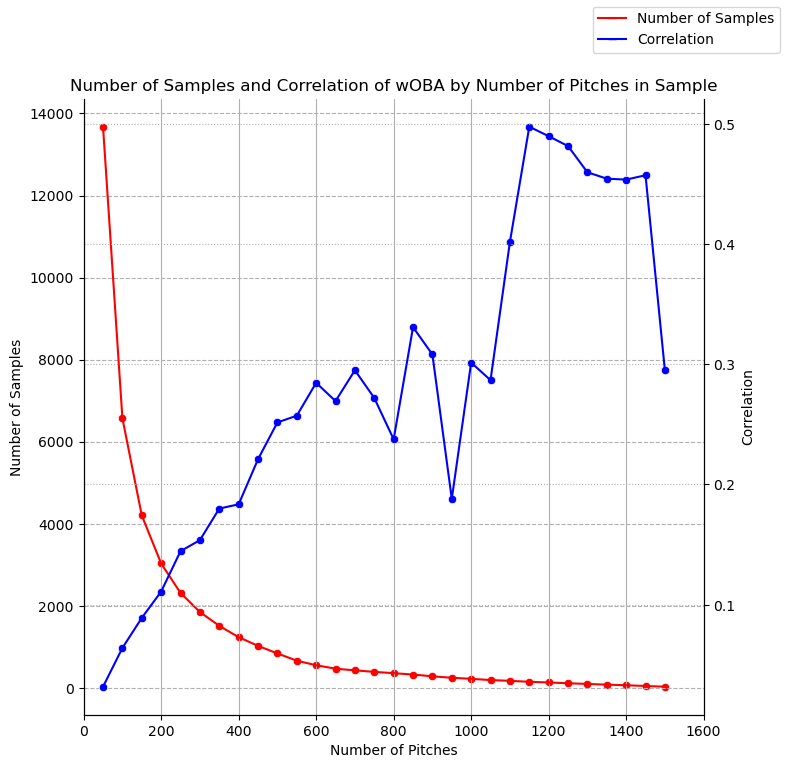

In [31]:
# create the figure and the first (left) axis
f, ax = plt.subplots(figsize=(8, 8))

# plot the number of samples with points
# set to first (left) axis
sns.scatterplot(x='sample_size', y='num_samples', color='red', data=sample_size_df, ax=ax);

# plot lines connecting the number of samples
# set to first (left) axis
sns.lineplot(x='sample_size', y='num_samples', color='red', data=sample_size_df, ax=ax);

# create the second (right) axis
ax2 = ax.twinx()

# plot the correlation with points
# set to second (right) axis
sns.scatterplot(x='sample_size', y='correlation', color='blue', data=sample_size_df, ax=ax2);

# plot lines connecting the correlations
# set to second (right) axis
sns.lineplot(x='sample_size', y='correlation', color='blue', data=sample_size_df, ax=ax2);

# remove the top spine
# don't remove the right spine
sns.despine(fig=f, top=True, right=False);

# set x-axis limits between 0 and 1600
ax.set_xlim(left=0, right=1600);

# set title
plt.title("Number of Samples and Correlation of wOBA by Number of Pitches in Sample");
# set x-axis label 
ax.set_xlabel("Number of Pitches");
# set first (left) y-axis label
ax.set_ylabel("Number of Samples");
# set second (right) y-axis label
ax2.set_ylabel("Correlation");

# set grid on x-axis
# default linestyle is solid lines
ax.grid(axis='x');
# set grid on first (left) y-axis
ax.grid(axis='y', linestyle='--');
# set grid on second (right) y-axis
ax2.grid(axis='y', linestyle=':');

# set legend
f.legend(handles=[Line2D([], [], marker='_', color='red', label="Number of Samples"), 
                  Line2D([], [], marker='_', color='blue', label="Correlation")], loc=1);

Here is the correlation and the number of samples for each sample size of pitches from 50 to 1500 pitches, in increments of 50 pitches. 

As the sample size increases, wOBA stabilizes as each pitcher's samples have a stronger correlation with each other. However, beyond sample sizes of 1200 pitches, the samples become less correlated with each other. This can be explained by the number of samples decreasing as the sample size increases. With fewer samples for each pitcher to compare, the correlation is more succeptible to outliers in sample wOBA.

Looking at wOBA in appearances is much too small a sample to consider. Starting pitchers generally won't throw more than 150 pitches in a game, and relievers generally throw less than 50 pitches. It is clear that both sample sizes are much too small for wOBA to stabilize, and do a poor job of reflecting the pitcher's "true wOBA skill" due to their weak correlation with other samples of the same size.

The sample sizes of interest for using to model a change in wOBA as use changes, that is the sample size that best stabilizes wOBA while allowing for the most possible samples, appears to be between 1100 and 1300 pitches. The above plot will be restricted to be between these numbers to show the number of samples with more precision.

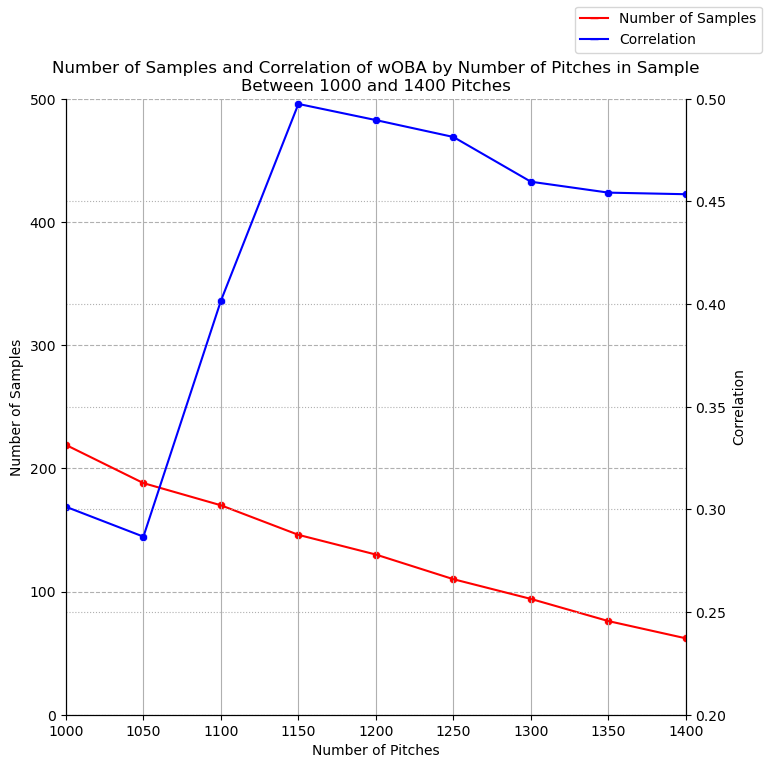

In [32]:
# create the figure and the first (left) axis
f, ax = plt.subplots(figsize=(8, 8))

# plot the number of samples with points
# set to first (left) axes
sns.scatterplot(x='sample_size', y='num_samples', color='red', data=sample_size_df, ax=ax);

# plot lines connecting the number of samples
# set to first (left) axes
sns.lineplot(x='sample_size', y='num_samples', color='red', data=sample_size_df, ax=ax);

# create the second (right) axes
ax2 = ax.twinx()

# plot the correlation with points
# set to second (right) axes
sns.scatterplot(x='sample_size', y='correlation', color='blue', data=sample_size_df, ax=ax2);

# plot lines connecting the correlations
# set to second (right) axes
sns.lineplot(x='sample_size', y='correlation', color='blue', data=sample_size_df, ax=ax2);

# remove the top border
# don't remove the right border
sns.despine(fig=f, top=True, right=False);

# set x-axis limits between 1000 and 1400
ax.set_xlim(left=1000, right=1400);
# set first (left) y-axis limits between 0 and 500
ax.set_ylim(bottom=0, top=500);
# set second (right) y-axis limits between 0.2 and 0.5
ax2.set_ylim(bottom=0.2, top=0.5);

# set title
# use newline escape character to split title into two lines
plt.title("Number of Samples and Correlation of wOBA by Number of Pitches in Sample\nBetween 1000 and 1400 Pitches");
# set x-axis label 
ax.set_xlabel("Number of Pitches");
# set first (left) y-axis label
ax.set_ylabel("Number of Samples");
# set second (right) y-axis label
ax2.set_ylabel("Correlation");

# set grid on x-axis
# default linestyle is solid lines
ax.grid(axis='x');
# set grid on first (left) y-axis
ax.grid(axis='y', linestyle='--');
# set grid on second (right) y-axis
ax2.grid(axis='y', linestyle=':');

# set legend
f.legend(handles=[Line2D([], [], marker='_', color='red', label="Number of Samples"), 
                  Line2D([], [], marker='_', color='blue', label="Correlation")], loc=1);

Between 1000 and 1400 pitches, the number of samples decreases almost linearly, this means that when considering sample size, each increment of 50 pitches will cause close to a constant decrease of samples. Since the relationship between number of samples and the sample size is not "flat" anywhere (there's no region where increments have little effect on the number of samples), the selection should favour a smaller choice of sample size within the 1000 and 1400 pitches.

The sample size that I believe best stabilizes wOBA while allowing for the most samples is 1150 pitches. This is the sample size of pitches that I will use to fit a model on.

<a id='Discussion'></a>

# Section 7 - Discussion

In this project, wOBA was calculated in samples of pitches. This is not an intuitive sample to use for measuring wOBA, as only the pitches that end a plate appearance have an effect on the pitcher's wOBA in that sample and the pitches in plate appearances that are called or swinging strikes, balls, or foul balls have no effect. If a pitcher had a fewer proportion of pitches ending a plate appearance in a sample (or a pitcher consistently has a high number of pitches per plate appearance), their sample(s) at a given number of pitches may be prone to random error due to small implicit sample size than samples of pitchers with a high proportion of plate appearance-ending pitches. This choice to accept the possibility of random error due to smaller implicit sample size in the samples was an intentional choice in this series of projects to better reflect a pitcher's "true pitch mix" of their pitches in the samples. If the samples of pitches were created from pitches that ended plate appearances (equivalent to creating samples of plate appearances), the percentage of each pitch type in the sample would reflect the pitcher's plate appearances by the last pitch thrown, rather than their pitch mix including those that don't often result in an event ending a plate appearance (including, but not limited to, pitch types that are disproportionately used early in the count or pitch types that have a low Contact% and are rarely used with three balls). In measuring the change in wOBA as a consequence of a change in pitch use, which is my application of the results of this project, samples more accurately representing the pitcher's "true use percentage" are preferred.

To reflect the "true pitch mix", and to measure with samples where all data within the sample is used in the statistic, wOBA is not the best choice of measuring performance. A better choice of statistic in this regard is one that reflects the value of non-plate appearance-ending pitches on run scoring (prevention), some examples of these statistics are [Pitch Values](https://library.fangraphs.com/pitching/linear-weights/) and [Pitching+](https://library.fangraphs.com/pitching/stuff-location-and-pitching-primer/). The result of this project, and this series of projects, may serve well to be repeated with a statistic that reflects the effect on run scoring across all pitch scenarios, rather than only by plate appearance-ending events as wOBA does.

When creating samples of pitches the number of pitches that each pitcher threw were grouped to create even samples of the sample size, meaning that "extra" pitches beyond the number of samples for each pitcher times the sample size were discarded. Inclusion of these discarded pitches wouldn't necessarily create sampling error, though my concern with including these would be that pitchers who threw few more pitches than their even samples would have smaller samples of pitches than pitchers who threw few less pitches than enough to create a new sample of the sample size. For (perhaps an extreme) example, when calculating wOBA in samples of 500 pitches, consider two pitchers, Pitcher A threw 1001 pitches, and Pitcher B threw 1499 pitches. Both pitchers will have two samples of 500 pitches, Pitcher A will samples of size 501 and 500, and Pitcher B will have samples of size 750 and 749. Since the correlation between samples of pitches is stronger as the sample increases, it is reasonable to conclude that a stronger correlation between Pitcher B's samples than Pitcher A's may be explained by the extra pitches and not the stability of wOBA at a sample size of 500 pitches. Though the overall correlation at a sample size likely would not be any weaker when including these discarded pitches (this project used the lower bound of data at each sample size), it was an intentional choice in this project not to need to consider a disproportionately high percentage of pitchers having few less pitches than enough to create a new sample at a given sample size. The result of this project may serve well to be repeated with including these pitches.

The number of samples decreasing as the sample size increasing was an intuitive result. It appeared that wOBA stabilized as the sample size did, until there became too few samples to reliably compare between-sample correlation for pitchers, then leveled-off and destabilized with an increase in the sample size. Though there are millions of pitches thrown by hundreds of pitchers each season, creating large samples of these pitches for each pitcher rapidly decreases the number of pitchers who have thrown that many, not to mention requiring a pitcher to throw twice the sample for inclusion. It is reasonable to believe that, with an infinite (or at least larger) sample of pitches from each pitcher than available in the 2022 season, wOBA would stabilize further and correlation would increase beyond the values seen in this project. Including data from previous seasons would be a solution to increase the number of pitches in the data for each pitcher. It was an intentional choice in this project to limit the data to the 2022 season, though the choice was made more with the series of projects in mind than this project. The goal of this series of projects is to optimize each pitcher's pitch mix, and part of that process includes establishing the current pitch mix of each pitcher. It is my (unsupported and anecdotal) belief that pitchers are more likely to noticeably alter their pitch mix (by adding a new pitch type, dropping a pitch type, or reimagining and increasing the use of a current pitch type) between seasons than during a season. Altering their pitch mix a substantial amount, by the standards of this project, makes them a different pitcher. Using data over a period that may be more prone to this would introduce unneccessary complexity beyond the initial scope. Should the sample size of 1150 pitches established in this project serve to be a reliable sample for modeling change in wOBA by changing pitch use the trade-off of the smaller sample would be worth it not to be concerned with the possibility of changes in pitch mix beyond what is done in-season. Though the results of this project, and the series of projects may serve well to be repeated with including data from multiple seasons.

<a id='References'></a>

# Section 8 - References